# Checking Variable calculation with ERA5
Calculate variables for year 2020 using ERA5 data.
Compare with the variables that Suzana calculated using matlab script to make sure they match.
More the figures generated by this script is available in the pdf file "TCGI_singleyear_check_ERA5.pdf"

Variable list:
- Absolute Vorticity @ 850 hPa [s-1]
- Vertical Wind Shear between 850- & 200-hPa [m s-1]
- Column Relative Humidity
- Saturation Deficit
- Potential Intensity [m s-1]

Notes:
- Subscript "r" represents variables that have been interpolated to resolution 2*2 degrees.
- Subscript "ref" represents variables from Suzana as my references.
- Only plotting January 2020 here, but the script is calculating the data for the whole year 2020.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import scipy.io
import os
from scipy.ndimage import gaussian_filter

%load_ext autoreload
%autoreload 2

import functions

In [2]:
path = "/xpt/berimbau.local/data1/suzana/ERA5/OriginalFiles2020/"
path_ref = "/data0/yxia/ERA5/Suzana/"

resolution = 2
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90+resolution, resolution)), 
                     'lon': (['lon'], np.arange(0, 360, resolution))})

# input one of the data to get the format of lat & lon * time
u = xr.open_dataset(path+"U_2020_monthly.nc").sel(level=850)
my_time = u.time; my_lat = u.latitude.data; my_lon = u.longitude.data

In [3]:
# Input land mask and regrid the resolution to 2*2 degree
land_mask = xr.open_dataset("/data0/yxia/ERA5/LandMask_ERA5.nc").lsm
expanded_mask = xr.DataArray(
    np.tile(land_mask.values, (len(my_time), 1, 1)),  # Repeat the array along the time dimension
    coords={'time': my_time, 'lat': my_lat, 'lon': my_lon},
    dims=['time', 'lat', 'lon']
)
regridder = xe.Regridder(expanded_mask, ds_out, 'bilinear', periodic=True)
mask_r = regridder(expanded_mask)

In [4]:
# Read matlab data from Suzana
def read_mat(path, var_name):
    ds_ref_raw = scipy.io.loadmat(os.path.expanduser(path))
    ds_ref = xr.DataArray(ds_ref_raw[var_name],
        coords={'lat': -ds_out.lat, 'lon': ds_out.lon, 'time': my_time,}, 
        dims= ['lat', 'lon', 'time'],
    )
    ds_ref = ds_ref.transpose('time', 'lat', 'lon').sortby('lat')
    return ds_ref

### 1. Checking Absolute vorticity

In [24]:
# Input data
u = xr.open_dataset(path+"U_2020_monthly.nc").sel(level=850).u
v = xr.open_dataset(path+"V_2020_monthly.nc").sel(level=850).v
# Calculate avort
avort = functions.absolute_vort(u,v).rename({'latitude': 'lat', 'longitude':'lon'})
# Regrid resolution to 2*2 degree
regridder = xe.Regridder(avort, ds_out, 'bilinear', periodic=True)
avort_r = regridder(avort).where(mask_r == 0)

# avort from Suzana
avort_ref = read_mat(path_ref+'AbsVort_850hPa_ERA5_2020_2deg.mat', 'avortI')

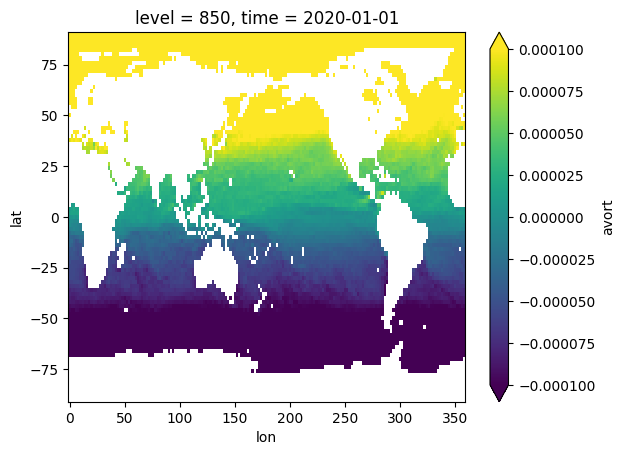

In [25]:
# Plot the my avort
(avort_r.avort[0]).plot(vmax=1e-04, vmin=-1e-04)

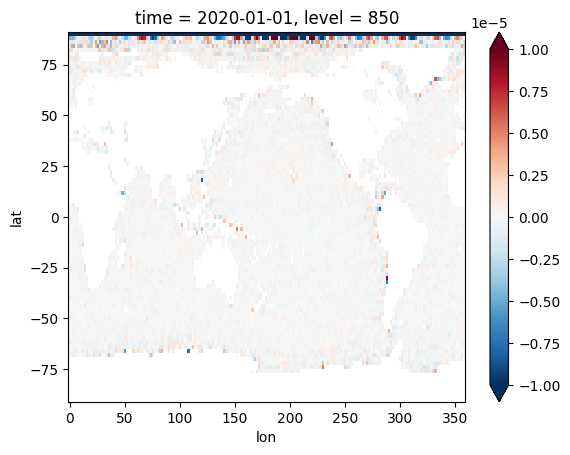

In [26]:
# Plot the differences between mine and Suzana's
(avort_ref[0] - avort_r.avort[0]).plot(vmax=1e-05, vmin=-1e-05, cmap='RdBu_r')

### 2. Checking vertical wind shear

In [27]:
# Input data
u = xr.open_dataset(path+"U_2020_monthly.nc").u
v = xr.open_dataset(path+"V_2020_monthly.nc").v
# Calculate wind shear
ws = functions.wind_shear(u,v, level_dim='level').rename({'latitude': 'lat', 'longitude':'lon'})
# Regrid resolution to 2*2 degree
regridder = xe.Regridder(ws, ds_out, 'bilinear', periodic=True)
ws_r = regridder(ws).where(mask_r == 0)

# ws from Suzana
ws_ref = read_mat(path_ref+'VerticalShear_ERA5_2020_2deg.mat', 'vshI')

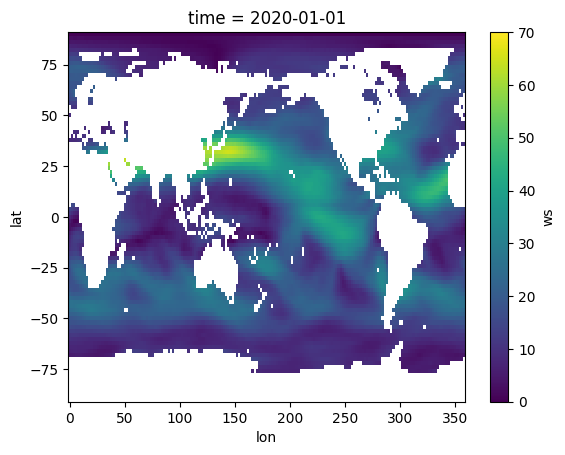

In [28]:
# Plot the my ws
(ws_r.ws[0]).plot(vmin=0, vmax=70)

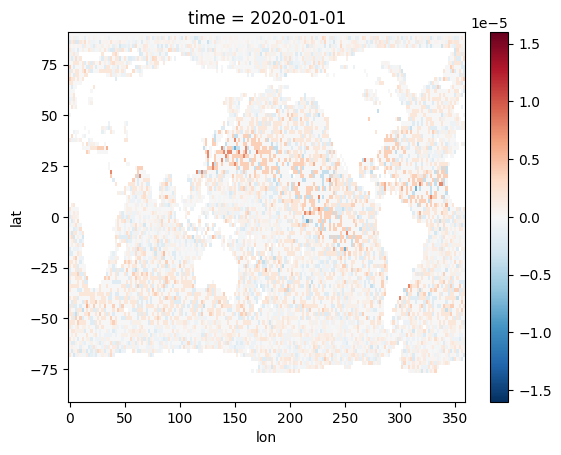

In [29]:
# Plot the differences between mine and Suzana's
(ws_ref[0]-ws_r.ws[0]).plot(vmin=-1.6e-5, vmax=1.6e-5, cmap='RdBu_r')

### 3. Checking CRH and SD

In [30]:
# Input data
ta = xr.open_dataset(path+"T_2020_monthly.nc").t
msl = xr.open_dataset(path+"MSLP_2020_monthly.nc").msl
skt = xr.open_dataset(path+"SkinTemp_2020_monthly.nc").skt
# Calculate CRH and SD
swv = functions.saturated_water_vapor(ta, msl, skt, level_dim='level').swv
tcwv = xr.open_dataset(path+"TCWV_2020_monthly.nc").tcwv.sortby("latitude")
CRH = (tcwv / swv).rename({'latitude': 'lat', 'longitude':'lon'})
SD = (tcwv - swv).rename({'latitude': 'lat', 'longitude':'lon'})
# Regrid resolution to 2*2 degree
regridder = xe.Regridder(CRH, ds_out, 'bilinear', periodic=True)
CRH_r = regridder(CRH).where(mask_r == 0)
regridder = xe.Regridder(SD, ds_out, 'bilinear', periodic=True)
SD_r = regridder(SD).where(mask_r == 0)

# CRH and SD from Suzana
CRH_ref = read_mat(path_ref+'CRH_ERA5_2020_2deg.mat', 'crhI')
SD_ref = read_mat(path_ref+'SD_ERA5_2020_2deg.mat', 'sdI')

/home/yxia/.conda/envs/yxia/lib/python3.11/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/yxia/.conda/envs/yxia/lib/python3.11/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


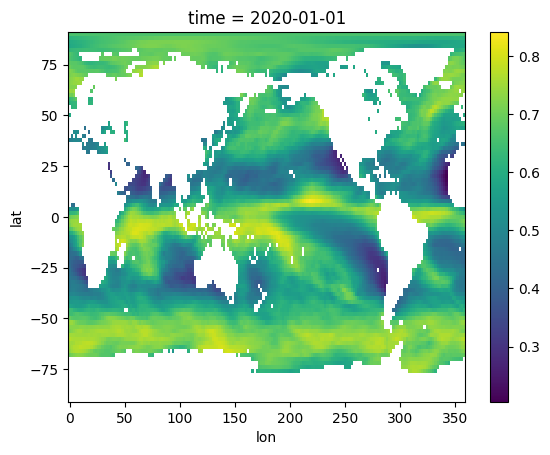

In [31]:
# Plot the my CRH
CRH_r[0].plot()

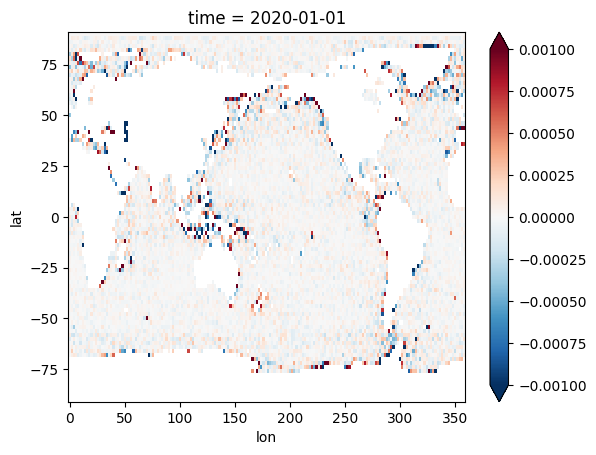

In [32]:
# Plot the differences between mine and Suzana's
(CRH_ref[0]-CRH_r[0]).plot(vmin=-0.001, vmax=0.001, cmap='RdBu_r')

### 4. Checking PI

In [45]:
# Input PI calculated using ./tcpyPI/run_PI_ERA5.py
PI = xr.open_dataset("/home/yxia/data/PI_ERA5_2020_2.nc").vmax
# Regrid resolution to 2*2 degree
regridder = xe.Regridder(PI, ds_out, 'bilinear', periodic=True)
PI_r = regridder(PI).where(mask_r == 0)

# PI from Suzana
PI_ref = read_mat(path_ref+'VelMax_PresMin_ERA5_PI_2020_2deg.mat', 'VmaxI')

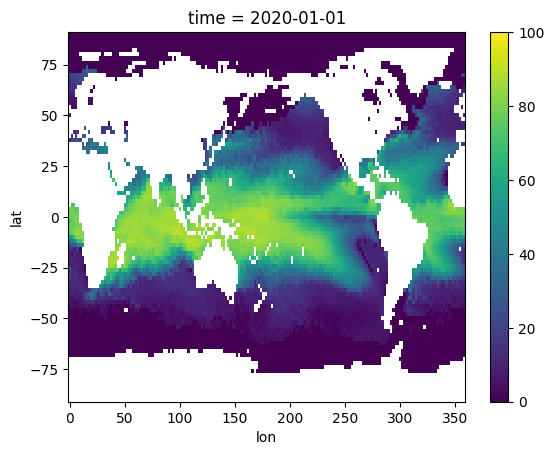

In [46]:
# Plot the my PI
PI_r[0].plot(vmin=0, vmax=100)

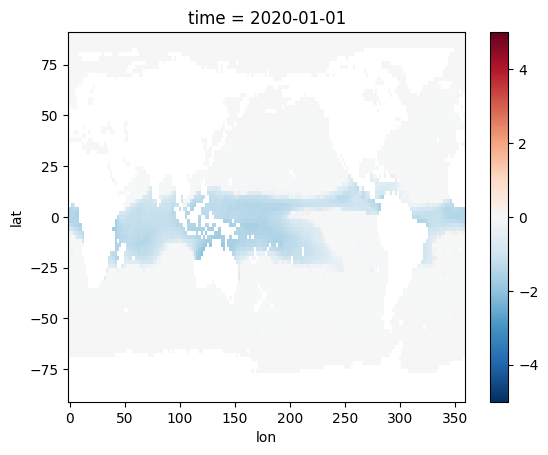

In [47]:
# Plot the differences between mine and Suzana's
(PI_ref-PI_r)[0].plot(vmin=-5, vmax=5, cmap='RdBu_r')

### 5. Checking two types of TCGI

In [48]:
vort = abs((avort_r.avort*1e+05)).clip(min=None, max=3.7)
humi1 = CRH_r * 100
humi2 = SD_r
ther = PI_r
shea = ws_r.ws

# coeffients from Suzana (calculated from ERA5 data)
b1 = [-24.1323, 2.5120, 0.0770, 0.0622, -0.1202]  # with CRH
b2 = [-18.3563, 2.4829, 0.0735, 0.0798, -0.1346]  # with SD

area = np.log(np.cos(np.deg2rad(my_lat))*2*2)
area_ext = np.tile(area, (len(my_time), len(my_lon), 1)).transpose(0,2,1)  # Rearrange dimensions to (time, lat, lon)
offset = xr.DataArray(area_ext, dims=['time', 'lat', 'lon'], 
                      coords={'time':my_time, 'lon': my_lon, 'lat': my_lat})

# calculate two types of TCGI (namely mu1 & mu2)
coe = 'b1'
mu1 = np.exp(eval(coe)[0] + eval(coe)[1]*vort + eval(coe)[2]*humi1 + 
            eval(coe)[3]*ther + eval(coe)[4]*shea + offset)
coe = 'b2'
mu2 = np.exp(eval(coe)[0] + eval(coe)[1]*vort + eval(coe)[2]*humi2 + 
            eval(coe)[3]*ther + eval(coe)[4]*shea + offset)

/tmp/ipykernel_200632/4287778852.py:11: RuntimeWarning: invalid value encountered in log
  area = np.log(np.cos(np.deg2rad(my_lat))*2*2)


In [39]:
# two TCGIs from Suzana
TCGI_crh_ref = read_mat(path_ref+'TCGI_CRH_PI_2020_ERA5_AYv1.mat', 'TCGI')
TCGI_sd_ref = read_mat(path_ref+'TCGI_SD_PI_2020_ERA5_AYv1.mat', 'TCGI')

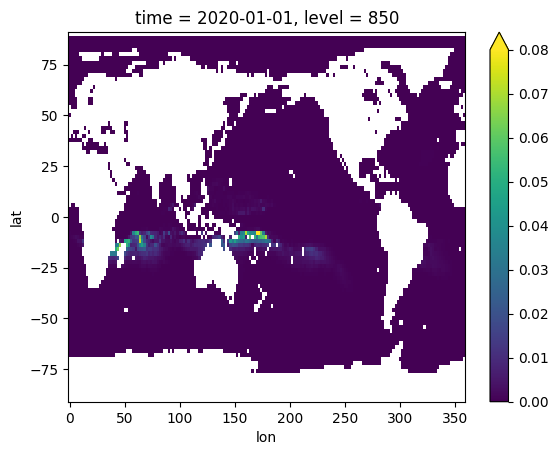

In [55]:
# Plot the my TCGI_CRH
mu1[0].plot(vmin=0, vmax=0.08)

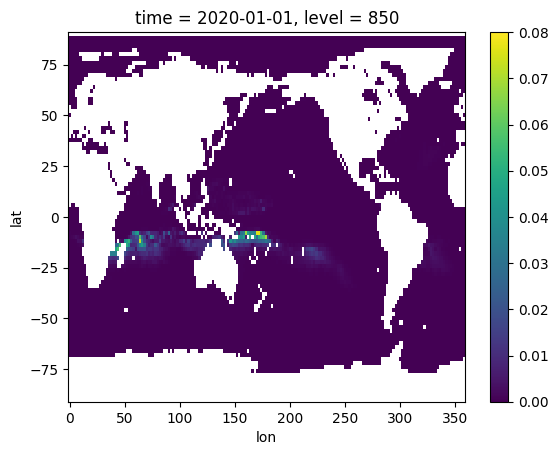

In [56]:
# Plot the my TCGI_SD
mu2[0].plot(vmin=0, vmax=0.08)

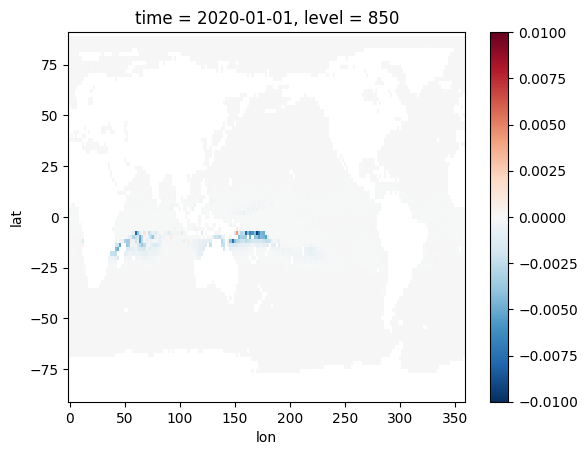

In [52]:
# Plot the differences between mine and Suzana's
(TCGI_crh_ref-mu1)[0].plot(vmax=0.01)

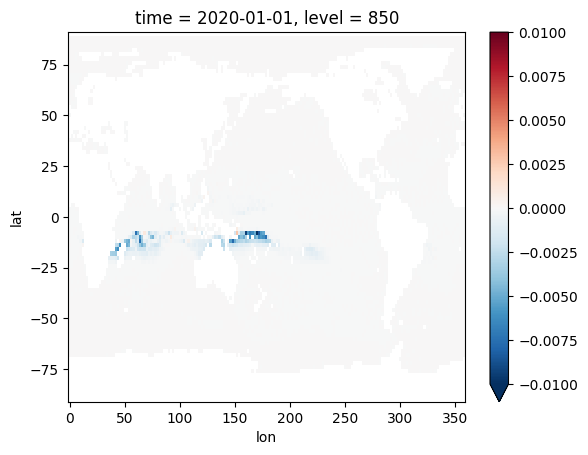

In [53]:
# Plot the differences between mine and Suzana's
(TCGI_sd_ref-mu2)[0].plot(vmax=0.01)